In [1]:
!pip install pandas numpy scikit-learn tensorflow -q

!pip install transformers tensorflowjs -q

!pip install datasets huggingface_hub tqdm tokenizers -q

!pip install -q matplotlib seaborn wordcloud plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.34.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [24]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, BatchNormalization,Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import tensorflowjs as tfjs
import json
import pickle
import re
import os
import random

In [5]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [6]:
# Set up GPU memory growth (if using GPU)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [7]:
splits = {
    'train': 'data/train-00000-of-00001.parquet',
    'balanced_test': 'data/balanced_test-00000-of-00001.parquet'
}

print("Loading datasets...")
train_df = pd.read_parquet("hf://datasets/tcapelle/jigsaw-toxic-comment-classification-challenge/" + splits["train"])
test_df = pd.read_parquet("hf://datasets/tcapelle/jigsaw-toxic-comment-classification-challenge/" + splits["balanced_test"])

Loading datasets...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [8]:
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import re
from collections import Counter
import warnings

In [11]:
target_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Creating a binary classification target
train_df['is_toxic'] = (train_df[target_columns].sum(axis=1) > 0).astype(int)
test_df['is_toxic'] = (test_df[target_columns].sum(axis=1) > 0).astype(int)

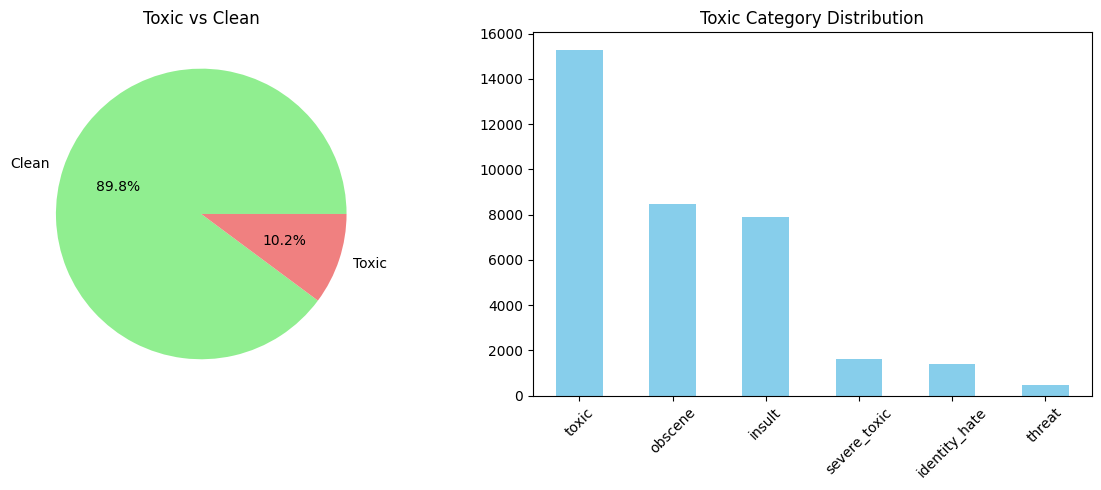

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 1. Toxic vs Clean pie chart
train_df['is_toxic'].value_counts().plot(
    kind='pie', ax=axes[0], autopct='%1.1f%%', labels=['Clean', 'Toxic'],
    colors=['lightgreen', 'lightcoral']
)
axes[0].set_title('Toxic vs Clean')
axes[0].set_ylabel('')

# 2. Toxic category distribution bar chart
train_df[target_columns].sum().sort_values(ascending=False).plot(
    kind='bar', ax=axes[1], color='skyblue'
)
axes[1].set_title('Toxic Category Distribution')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [13]:
print(f"Toxic percentage: {train_df['is_toxic'].mean():.2%}")

Toxic percentage: 10.17%


In [14]:
def preprocess_text(text):
    """Clean and preprocess text data"""
    if pd.isna(text):
        return ""

    # Convert to lowercase
    text = text.lower()

    # Remove special characters but keep spaces
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    # Remove extra whitespace
    text = ' '.join(text.split())

    return text

train_df['comment_text'] = train_df['comment_text'].apply(preprocess_text)
test_df['comment_text'] = test_df['comment_text'].apply(preprocess_text)

# Prepare the data
X_train = train_df['comment_text'].values
y_train = train_df['is_toxic'].values
X_test = test_df['comment_text'].values
y_test = test_df['is_toxic'].values

# Split training data for validation
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)


In [15]:
MAX_VOCAB_SIZE = 20000
MAX_SEQUENCE_LENGTH = 150
EMBEDDING_DIM = 128

tokenizer = Tokenizer(
    num_words=MAX_VOCAB_SIZE,
    oov_token="<OOV>",
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
)

tokenizer.fit_on_texts(X_train_split)

In [16]:
X_train_seq = tokenizer.texts_to_sequences(X_train_split)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences
X_train_padded = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_val_padded = pad_sequences(X_val_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

In [23]:
def create_cnn_model(vocab_size, embedding_dim, max_length):
    model = Sequential([
        # Explicit input layer
        Input(shape=(max_length,), dtype='int32', name='input'),

        # Embedding layer
        Embedding(vocab_size, embedding_dim, input_length=max_length),

        # First CNN layer
        Conv1D(128, 5, activation='relu'),
        BatchNormalization(),

        # Second CNN layer
        Conv1D(128, 5, activation='relu'),
        BatchNormalization(),

        # Third CNN layer
        Conv1D(128, 5, activation='relu'),
        BatchNormalization(),

        # Global max pooling
        GlobalMaxPooling1D(),

        # Dense layers
        Dense(128, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),

        Dense(64, activation='relu'),
        Dropout(0.3),

        # Output layer
        Dense(1, activation='sigmoid')
    ])

    return model

model = create_cnn_model(MAX_VOCAB_SIZE, EMBEDDING_DIM, MAX_SEQUENCE_LENGTH)

In [25]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [26]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=0.0001,
    verbose=1
)

callbacks = [early_stopping, reduce_lr]

# Train the model
print("Training model...")
history = model.fit(
    X_train_padded, y_train_split,
    batch_size=32,
    epochs=10,
    validation_data=(X_val_padded, y_val),
    callbacks=callbacks,
    verbose=1
)

Training model...
Epoch 1/10
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 46s 8ms/step - accuracy: 0.9040 - loss: 0.2738 - val_accuracy: 0.9551 - val_loss: 0.1319 - learning_rate: 0.0010
Epoch 2/10
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 64s 6ms/step - accuracy: 0.9552 - loss: 0.1274 - val_accuracy: 0.9504 - val_loss: 0.1464 - learning_rate: 0.0010
Epoch 3/10
3981/3990 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9679 - loss: 0.0902
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 44s 7ms/step - accuracy: 0.9679 - loss: 0.0902 - val_accuracy: 0.9518 - val_loss: 0.1538 - learning_rate: 0.0010
Epoch 4/10
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 39s 7ms/step - accuracy: 0.9807 - loss: 0.0564 - val_accuracy: 0.9481 - val_loss: 0.2046 - learning_rate: 5.0000e-04
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.


In [27]:
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test, verbose=0)
print(f"Test accuracy: {test_accuracy:.4f}")

Test accuracy: 0.8663


In [28]:
y_pred_prob = model.predict(X_test_padded)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.93      0.87      6243
           1       0.92      0.80      0.86      6243

    accuracy                           0.87     12486
   macro avg       0.87      0.87      0.87     12486
weighted avg       0.87      0.87      0.87     12486



In [29]:
model.save('toxic_comment_cnn_model.h5')

tokenizer_config = {
    'word_index': {k: v for k, v in tokenizer.word_index.items() if v < MAX_VOCAB_SIZE},
    'max_vocab_size': MAX_VOCAB_SIZE,
    'max_sequence_length': MAX_SEQUENCE_LENGTH,
    'oov_token': tokenizer.oov_token,
    'num_words': tokenizer.num_words,
    'filters': tokenizer.filters,
    'lower': tokenizer.lower,
    'split': tokenizer.split,
    'char_level': tokenizer.char_level
}

with open('tokenizer_config.json', 'w') as f:
    json.dump(tokenizer_config, f, indent=2)